In [34]:
import os
import datetime
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.optim as optim
import cv2
import dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [2]:
# Variables
DATASET_DIR = "../MIT_split/"
LABELS_DICT = {"Opencountry":0 ,  "coast":1,   "forest":2, "highway":3, "inside_city":4,  "mountain":5 , "street":6,  "tallbuilding":7}
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 16
EPOCHS = 10
INPUT_SIZE = 64
EXPERIMENTS_PATH = 'experiments'


In [3]:
# check for CUDA availability
if torch.cuda.is_available():
    print('CUDA is available, setting device to CUDA')
# set device to  CUDA for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available, setting device to CUDA


In [4]:
##Instantiate Tensorboard Writer
#Create log folders
train_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'train')
val_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'validation')
#Create summary writer
train_writer = SummaryWriter(log_dir=train_logdir)
val_writer = SummaryWriter(log_dir=val_logdir)


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader, test_loader = dataset.get_dataloaders(DATASET_DIR, INPUT_SIZE, BATCH_SIZE, kwargs)

In [6]:
len(train_loader)

118

In [7]:
# Set up the network and training parameters

from losses import ContrastiveLoss
import torchvision.models as models
margin = 1.

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 8)
cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [8]:
from train import fit
fit(train_loader, test_loader, model, criterion, optimizer, scheduler, EPOCHS, cuda, log_interval)


/home/marcelo/miniconda3/envs/T3-M1/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 2.376786
Train: [300/1881 (85%)]	Loss: 1.423556
Epoch: 1/10. Train set: Average loss: 1.3828
Epoch: 1/10. Validation set: Average loss: 0.6630
Train: [0/1881 (0%)]	Loss: 0.798347
Train: [300/1881 (85%)]	Loss: 0.935962
Epoch: 2/10. Train set: Average loss: 0.9161
Epoch: 2/10. Validation set: Average loss: 0.8007
Train: [0/1881 (0%)]	Loss: 0.574840
Train: [300/1881 (85%)]	Loss: 0.821104
Epoch: 3/10. Train set: Average loss: 0.8144
Epoch: 3/10. Validation set: Average loss: 0.5562
Train: [0/1881 (0%)]	Loss: 0.854477
Train: [300/1881 (85%)]	Loss: 0.706846
Epoch: 4/10. Train set: Average loss: 0.7152
Epoch: 4/10. Validation set: Average loss: 0.4948
Train: [0/1881 (0%)]	Loss: 1.231216
Train: [300/1881 (85%)]	Loss: 0.670590
Epoch: 5/10. Train set: Average loss: 0.6868
Epoch: 5/10. Validation set: Average loss: 0.4822
Train: [0/1881 (0%)]	Loss: 0.709603
Train: [300/1881 (85%)]	Loss: 0.611052
Epoch: 6/10. Train set: Average loss: 0.6198
Epoch: 6/10. Validation set: A

(array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3.,
        3., 3., 1., 6., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3.,
        3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 3., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 5., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 2., 2., 2., 2., 2.,
        2., 

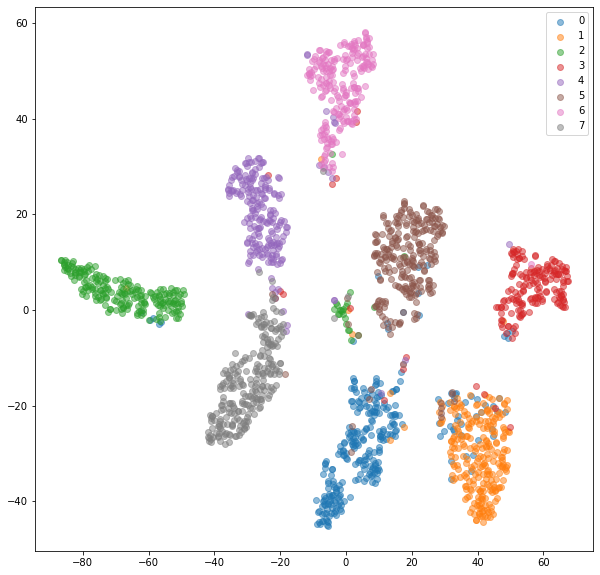

In [41]:
%matplotlib inline
from plot_emb import plot_embeddings, extract_embeddings
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    model_cut = nn.Sequential(*list(model.children())[:-2])
    with torch.no_grad():        
        model.eval()
        embeddings = np.empty((0,2048))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #print(images.shape)
            #print(model(images.float()).shape)
            #print(model_cut(images.float()).data.cpu().numpy().shape)
            embeddings = np.vstack((embeddings,model_cut(images.float()).data.cpu().numpy().reshape(-1,2048)))
            #print(embeddings.shape)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels
def fit_retrival(embeddings,labels,mode='knn'):
    if mode == 'knn':
        clf = neighbors.KNeighborsClassifier(n_neighbors=8)
        clf.fit(embeddings, labels)
    return clf
def predict_retrival(model,embeddings,labels):
    return model.predict(embeddings),model.score(embeddings,labels)
def plot_TSNE(embeddings):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2,
                 init='random').fit_transform(embeddings)
    return  X_embedded

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)

TSNE_embedding = plot_TSNE(train_embeddings_otl)
retrival_module = fit_retrival(train_embeddings_otl,train_labels_otl,mode='knn')

plot_embeddings(TSNE_embedding, train_labels_otl)


test_embeddings_otl, test_labels_otl = extract_embeddings(test_loader, model)
labels,score = predict_retrival(retrival_module,test_embeddings_otl, test_labels_otl)
print('score obtained equal to {}'.format(score))